In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import layers,models

In [4]:
# Defining Regularized loss function
def regloss(y_pred,y,w1,w2=0):
    batch_size=y_pred.shape[0] #determining the number of input data
    loss=(1/(batch_size))*(np.square(y-y_pred)).sum()+reg*(np.sum(w1*w1)+np.sum(w2*w2))
    return loss

In [5]:
# Defining accuracy function
def accuracy(y_pred,y):
    batch_size=y_pred.shape[0] #determining the number of input data
    K=y_pred.shape[1] # determining number of classes
    acc=1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    return acc

In [4]:
# definng the function to plot the analytics
def graphs(loss_history,loss_history_test,train_acc_history,val_acc_history,name,compare=False,n=2,labels=[]):
    lists=[loss_history,loss_history_test,train_acc_history,val_acc_history]
    titiles=["training loss","testing loss","training accuracy","testing accuracy"]
    fig,ax=plt.subplots(1,4,figsize=(25,5))
    for i in range(len(lists)):
        if compare:
            for j in range(n):
                ax[i].plot(lists[i][j],label=labels[j])
            ax[i].legend()  
        else:
            ax[i].plot(lists[i])
        ax[i].set_ylabel(titiles[i])
        ax[i].set_xlabel("epoch")
        ax[i].plot()
    fig.savefig(fname="metrics_"+name+".png",transparent=True)
    return None

In [5]:
# Defining function for data preprocessing
def preproc(norm,reshape):
    # Importing data set
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    K = len(np.unique(y_train)) # Classes #np.unique Find the unique elements of an array.
    Ntr = x_train.shape[0] # Number of training data
    Nte = x_test.shape[0] # Number of testing data
    Din = x_train.shape[1]*x_train.shape[2]*x_train.shape[3] # CIFAR10

    if norm:
        # Normalize pixel values
        x_train, x_test = x_train / 255.0, x_test / 255.0

    # Centering pixel values
    mean_image = np.mean(x_train, axis=0)
    x_train = x_train - mean_image
    x_test = x_test - mean_image

    # One hot encoding the labels
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

    #flatterning the input images and changing the data type
    if reshape:
        x_train = np.reshape(x_train,(Ntr,Din))
        x_test = np.reshape(x_test,(Nte,Din))
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print('x_train:', x_train.shape)
    print('x_test:', x_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)
    return x_train,y_train,x_test,y_test

# Linear Classifier

In [9]:
# Defining linear Classifier function
def linclas(x_train,y_train,x_test,y_test,lr,lr_decay,reg):
    Ntr = x_train.shape[0] # Number of training data
    Nte = x_test.shape[0] # Number of testing data
    Din = x_test.shape[1]
    K = y_test.shape[1]
    batch_size=x_train.shape[0]

    loss_history = []
    loss_history_test = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    # Initializing weight and bias arrays
    Din=x_train.shape[1]
    std=1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    for t in range(iterations):
        # shuffling the training data set to randomize the training process.To prevent overfitting
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]

        # forward pass
        y_pred=x.dot(w1)+b1
        y_pred_test=x_test.dot(w1)+b1

        # calculating loss
        train_loss=regloss(y_pred,y,w1)
        test_loss=regloss(y_pred_test,y_test,w1)
        loss_history.append(train_loss)
        loss_history_test.append(test_loss)
        
        # calculating accuracy
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('epoch %d/%d: loss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw1=x.T.dot(dy_pred)+reg*w1
        db1=dy_pred.sum(axis=0)

        # updating parameters
        w1-=lr*dw1
        b1-=lr*db1
        lr*=lr_decay
    return w1,b1,loss_history,loss_history_test,train_acc_history,val_acc_history

In [10]:
#defining parameters and running the linear classifier
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lamda(regularization constant for the loss function)
x_train,y_train,x_test,y_test=preproc(norm=True,reshape=True)
w1,b1,loss_history,loss_history_test,train_acc_history,val_acc_history=linclas(x_train,y_train,x_test,y_test,lr,lr_decay,reg)

x_train: (50000, 3072)
x_test: (10000, 3072)
y_train: (50000, 10)
y_test: (10000, 10)
epoch 0/300: loss= 1.000026-- ,test loss= 1.000019--,train accracy= 0.663814--, test accracy= 0.668510
epoch 10/300: loss= 0.876635-- ,test loss= 0.876234--,train accracy= 0.756448--, test accracy= 0.758120
epoch 20/300: loss= 0.842539-- ,test loss= 0.842415--,train accracy= 0.762638--, test accracy= 0.767790
epoch 30/300: loss= 0.823615-- ,test loss= 0.823714--,train accracy= 0.766474--, test accracy= 0.770730
epoch 40/300: loss= 0.812388-- ,test loss= 0.812706--,train accracy= 0.768642--, test accracy= 0.771540
epoch 50/300: loss= 0.805425-- ,test loss= 0.805969--,train accracy= 0.770302--, test accracy= 0.772830
epoch 60/300: loss= 0.800905-- ,test loss= 0.801678--,train accracy= 0.771568--, test accracy= 0.773540
epoch 70/300: loss= 0.797821-- ,test loss= 0.798823--,train accracy= 0.772706--, test accracy= 0.773590
epoch 80/300: loss= 0.795604-- ,test loss= 0.796834--,train accracy= 0.773764--, te

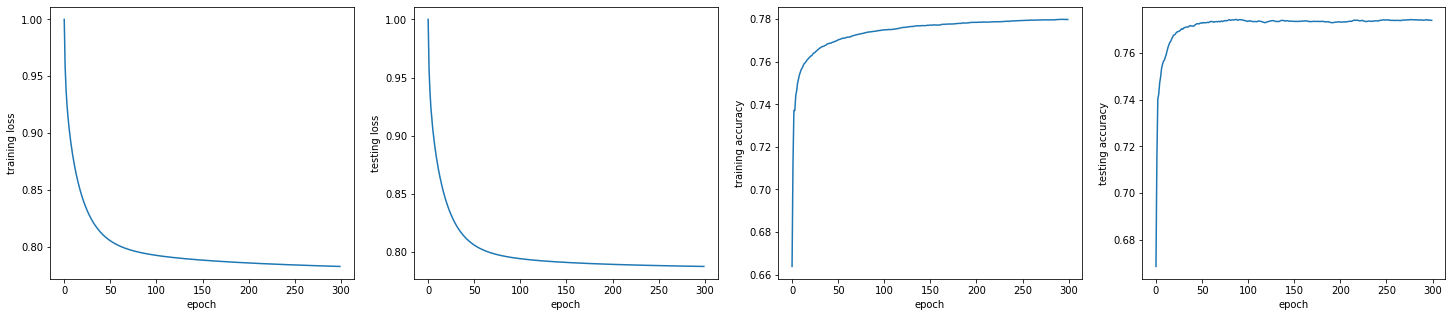

In [11]:
# ploting metrics
graphs(loss_history,loss_history_test,train_acc_history,val_acc_history,"linear classifier")

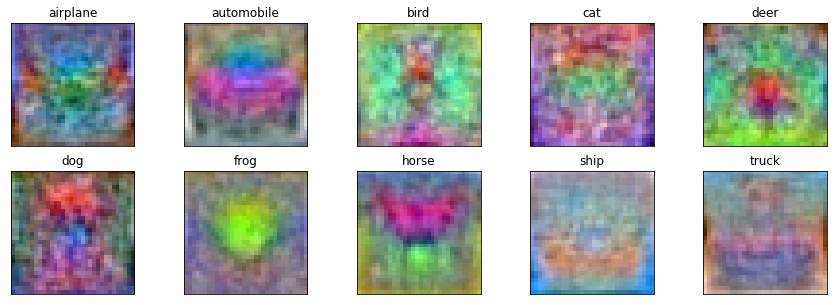

In [14]:
images=[]
titles=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(w1.shape[1]):
    temp=np.reshape(w1[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
fig,ax=plt.subplots(2,5,figsize=(15,5))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(titles[i*5+j])
plt.show()
fig.savefig("w1_images.png",transparent=True)

# 2 Layer Dense Network

In [10]:
# defining two layer dense network
def layer2(x_train,y_train,x_test,y_test,batch_size,H,lr,lr_decay,reg):
    Din=x_train.shape[1]
    K=y_train.shape[1]
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    loss_history = []
    loss_history_test = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    #initializing weight and bias arrays
    std=1e-5
    w1 = (2/(Ntr*Din))**0.5*np.random.randn(Din, H)
    w2 = (2/(H*Din))**0.5*np.random.randn(H, K)
    b1 = np.zeros(H)
    b2 = np.zeros(K)

    for t in range(iterations):
        # mini batching the training data set
        indices = np.random.choice(Ntr,batch_size)
        # shuffling the training data set to avoid overfitting
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]

        #forward pass
        h=1/(1+np.exp(-(x.dot(w1)+b1)))
        h_test=1/(1+np.exp(-((x_test).dot(w1)+b1)))
        y_pred=h.dot(w2)+b2
        y_pred_test=h_test.dot(w2)+b2

        # calculating the loss
        train_loss=regloss(y_pred,y,w1,w2)
        test_loss=regloss(y_pred_test,y_test,w1,w2)
        loss_history.append(train_loss)
        loss_history_test.append(test_loss)
        
        # calculating accuracy
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('epoch %d/%d: loss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw2=h.T.dot(dy_pred)+reg*w2
        db2=dy_pred.sum(axis=0)
        dh=dy_pred.dot(w2.T)
        dw1=x.T.dot(dh*h*(1-h))+reg*w1
        db1=(dh*h*(1-h)).sum(axis=0)

        # updating parameters
        w1-=lr*dw1
        b1-=lr*db1
        w2-=lr*dw2
        b2-=lr*db2
        lr*=lr_decay
    return w1,b1,w2,b2,loss_history,loss_history_test,train_acc_history,val_acc_history

In [19]:
x_trainn,y_trainn,x_testn,y_testn=preproc(norm=False,reshape=True)
batch_size = x_trainn.shape[0]
H=200
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6
w1n,b1n,w2n,b2n,loss_historyn,loss_history_testn,train_acc_historyn,val_acc_historyn=layer2(x_trainn,y_trainn,x_testn,y_testn,batch_size,H,lr,lr_decay,reg)

x_train: (50000, 3072)
x_test: (10000, 3072)
y_train: (50000, 10)
y_test: (10000, 10)
epoch 0/300: loss= 0.986170-- ,test loss= 0.986113--,train accracy= 0.638416--, test accracy= 0.636260
epoch 10/300: loss= 0.822692-- ,test loss= 0.823000--,train accracy= 0.750490--, test accracy= 0.753510
epoch 20/300: loss= 0.815615-- ,test loss= 0.816527--,train accracy= 0.763822--, test accracy= 0.761040
epoch 30/300: loss= 0.803313-- ,test loss= 0.804134--,train accracy= 0.768686--, test accracy= 0.765420
epoch 40/300: loss= 0.792379-- ,test loss= 0.794249--,train accracy= 0.771040--, test accracy= 0.769280
epoch 50/300: loss= 0.791094-- ,test loss= 0.794619--,train accracy= 0.768678--, test accracy= 0.768660
epoch 60/300: loss= 0.794087-- ,test loss= 0.797422--,train accracy= 0.767488--, test accracy= 0.764500
epoch 70/300: loss= 0.788344-- ,test loss= 0.792760--,train accracy= 0.767222--, test accracy= 0.764910
epoch 80/300: loss= 0.778158-- ,test loss= 0.783180--,train accracy= 0.776624--, te

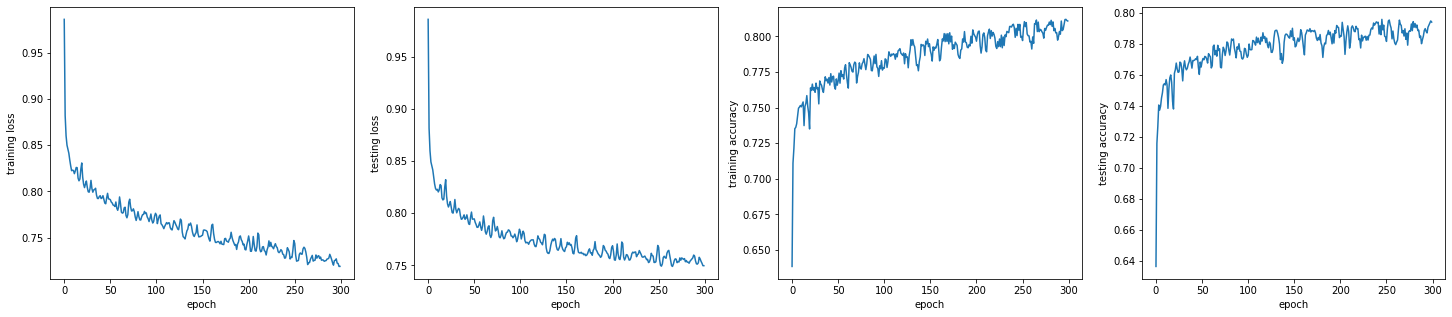

In [20]:
graphs(loss_historyn,loss_history_testn,train_acc_historyn,val_acc_historyn,"2 layer dense")

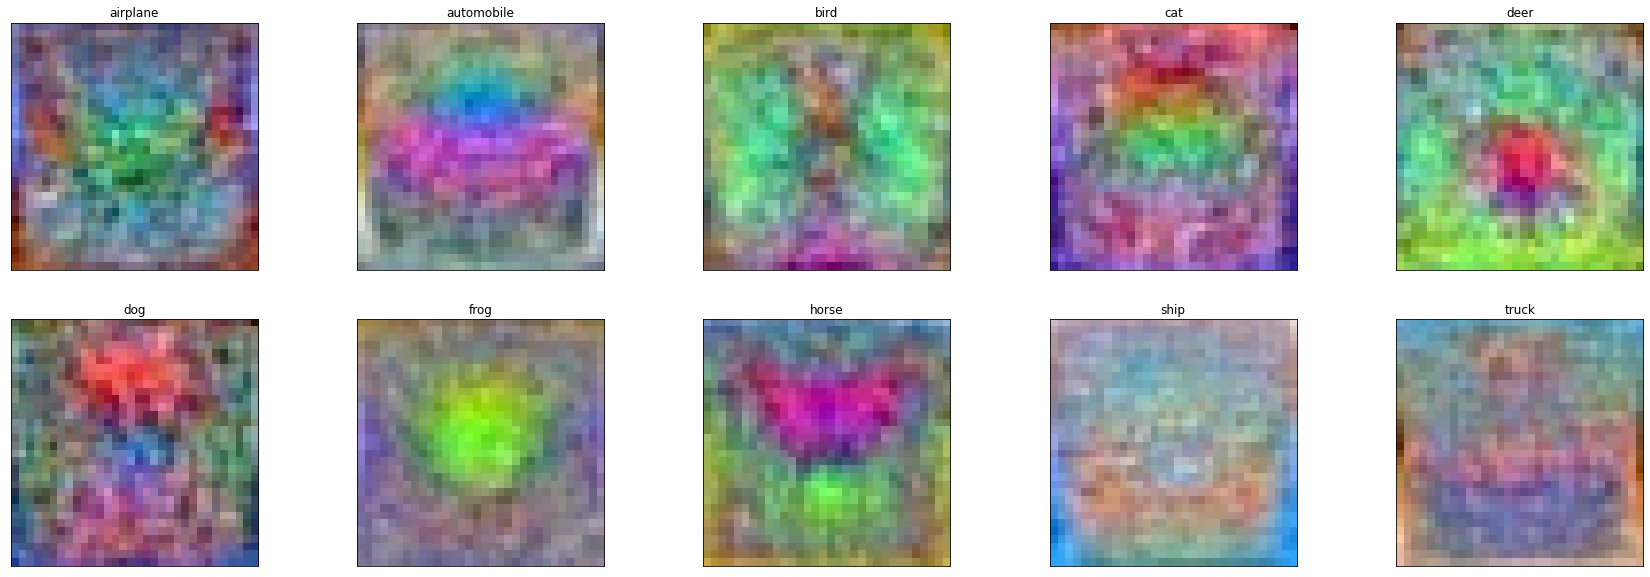

In [26]:
images=[]
w12=(1/(1+np.exp(-w1n))).dot(w2n)
titles=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(w12.shape[1]):
    temp=np.reshape(w12[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
fig,ax=plt.subplots(2,5,figsize=(30,10))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(titles[i*5+j])
plt.show()
fig.savefig("w12_images.png",transparent=True)

# With batching

In [27]:
batch_size = 500
H=200
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6
x_trainn,y_trainn,x_testn,y_testn=preproc(norm=False,reshape=True)
w1m,b1m,w2m,b2m,loss_historym,loss_history_testm,train_acc_historym,val_acc_historym=layer2(x_trainn,y_trainn,x_testn,y_testn,batch_size,H,lr,lr_decay,reg)

x_train: (50000, 3072)
x_test: (10000, 3072)
y_train: (50000, 10)
y_test: (10000, 10)
epoch 0/300: loss= 1.001103-- ,test loss= 1.002740--,train accracy= 0.582600--, test accracy= 0.605140
epoch 10/300: loss= 0.832184-- ,test loss= 0.833281--,train accracy= 0.731600--, test accracy= 0.723830
epoch 20/300: loss= 0.813829-- ,test loss= 0.819375--,train accracy= 0.744200--, test accracy= 0.755150
epoch 30/300: loss= 0.797624-- ,test loss= 0.812948--,train accracy= 0.741000--, test accracy= 0.742800
epoch 40/300: loss= 0.814984-- ,test loss= 0.800920--,train accracy= 0.741800--, test accracy= 0.764340
epoch 50/300: loss= 0.813257-- ,test loss= 0.805600--,train accracy= 0.740800--, test accracy= 0.749940
epoch 60/300: loss= 0.800652-- ,test loss= 0.793206--,train accracy= 0.776000--, test accracy= 0.773890
epoch 70/300: loss= 0.794926-- ,test loss= 0.794827--,train accracy= 0.758200--, test accracy= 0.759960
epoch 80/300: loss= 0.791903-- ,test loss= 0.792136--,train accracy= 0.778000--, te

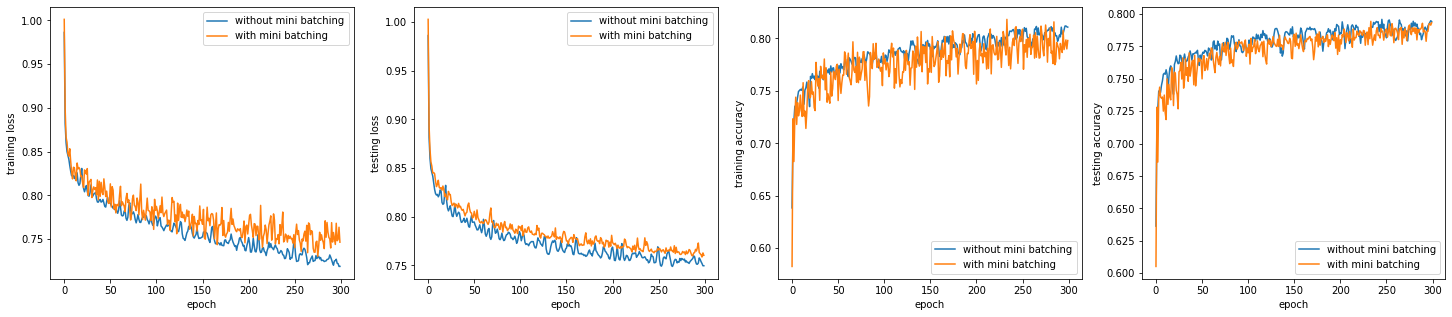

In [28]:
graphs([loss_historyn,loss_historym],[loss_history_testn,loss_history_testm],[train_acc_historyn,train_acc_historym],[val_acc_historyn,val_acc_historym],"2 layer dense with mini batching",compare=True,n=2,labels=["without mini batching","with mini batching"])

# CNN

In [3]:
x_trainc,y_trainc,x_testc,y_testc=preproc(norm=True,reshape=False)

NameError: name 'preproc' is not defined

In [2]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))

model.summary()

tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name="SGD")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [ ]:
model.compile(optimizer='SGD',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history=model.fit(x_trainc,y_trainc,epochs=20,batch_size=50,validation_data=(x_testc,y_testc),)

{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


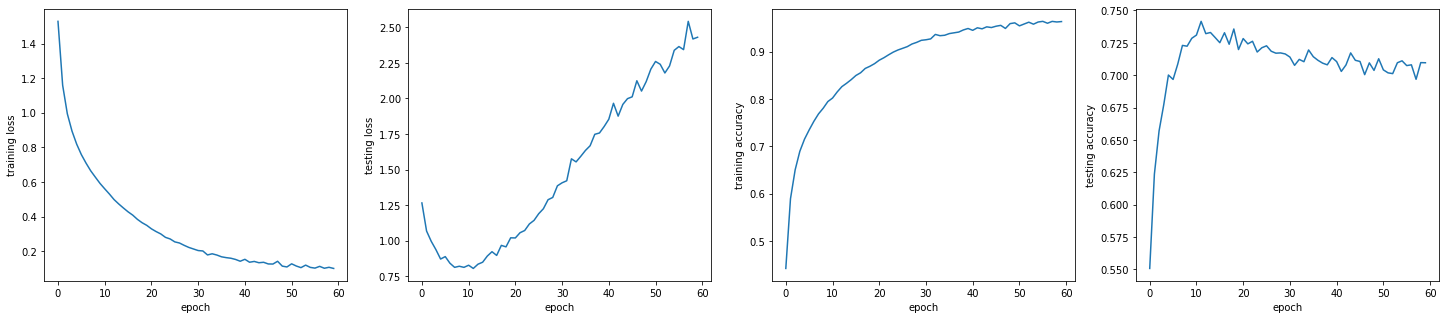

In [32]:
print(model.optimizer.get_config())
graphs(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'],"CNN")